# Hybrid A star algorithm
- control action : steering angle sets

In [14]:
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import random
import time
import sys
from IPython.display import clear_output
from scipy.spatial.transform import Rotation as Rot
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [75]:
DIST_TH = 1 # [m]
YAW_TH = 5 # [deg]
DX = 1 # [m]
X_EXPAND = 4 # [m]
L = 4 # [m]
MAX_STEER = 40
DSTEER = 5
COL_TH = 1 # [m]

XY_RESOLUTION = 2 # [m]
YAW_RESOLUTION = 15 #[deg]

DC_COST = 100 # direction change cost
D_COST = 5 # direction cost (penaly in the reverse direction)
H_COST = 40 # heuristic cost
S_COST = 20 # steering  cost

MAP_X_LIM = [-30, 30]
MAP_Y_LIM = [-30, 30]

# Vehicle parameters - for plot 
gain = 4.5/3.9
LENGTH = 3.9 * gain # [m]
WIDTH = 1.9 * gain # [m]
BACKTOWHEEL = 1 * gain # [m]
WHEEL_LEN = 0.3 * gain # [m]
WHEEL_WIDTH = 0.2 * gain  # [m]
TREAD = 0.7 * gain # [m]
WB = 2.2 * gain # [m]

show_animation  = True

In [76]:
class Node:
    def __init__(self, x_ind, y_ind, yaw_ind, x_list, y_list, yaw_list, direction, parent=None, position=None):
        self.parent = parent
        self.x = position[0]
        self.y = position[1]
        self.yaw = position[2]
        self.yaw = np.arctan2(np.sin(np.deg2rad(self.yaw)), np.cos(np.deg2rad(self.yaw)))
        self.yaw = np.rad2deg(self.yaw)
        self.direction = direction
        
        self.x_index = x_ind
        self.y_index = y_ind    
        self.yaw_index = yaw_ind
        
        self.x_list = x_list
        self.y_list = y_list
        self.yaw_list = yaw_list
        
        self.f = 0
        self.g = 0
        self.h = 0
        
    def __eq__(self, other):
        if (self.x == other.x) and (self.y == other.y):
            return True

In [77]:
def heuristic(cur_node, goal_node):
    dist = np.sqrt((cur_node.x - goal_node.x)**2 + (cur_node.y  - goal_node.y)**2 + (np.deg2rad(cur_node.yaw  - goal_node.yaw))**2)
    return dist 

In [78]:
def get_action():
    # steering angle, direction
    for steer in np.arange(-MAX_STEER, MAX_STEER, DSTEER):
        for direction in [-1, 1]:
            
            yield steer, direction

In [79]:
def collision_check(omap, node):
    nx = node[0]
    ny = node[1]
    ox = omap[0]
    oy = omap[1]
    
    col = False

    for i in range(len(ox)):
        if np.sqrt((nx-ox[i])**2 + (ny-oy[i])**2) < np.sqrt(LENGTH**2/4 + WHEEL_WIDTH**2/4):
            col = True
            break
            
    if nx <= MAP_X_LIM[0] or nx >= MAP_X_LIM[1] or ny <= MAP_Y_LIM[0] or ny >= MAP_Y_LIM[1]:
        col = True

    return col

In [80]:
def check_goal_condition(cur_node, goal_node):
    cur_x = cur_node.x
    cur_y = cur_node.y
    cur_yaw = cur_node.yaw
    
    goal_x = goal_node.x
    goal_y = goal_node.y
    goal_yaw = goal_node.yaw
    
    xy_diff = np.sqrt((cur_x - goal_x)**2 + (cur_y - goal_y)**2)
    yaw_diff = np.abs(cur_yaw - goal_yaw)
    
    if xy_diff < DIST_TH and yaw_diff < YAW_TH:
        return True
    else:
        return False

In [81]:
def vehicle_model(_x, _y, _yaw, _steer, d):   
    x = _x + DX*np.cos(np.deg2rad(_yaw)) * d
    y = _y + DX*np.sin(np.deg2rad(_yaw)) * d
    yaw = _yaw + np.rad2deg(DX*(1/L)*np.tan(np.deg2rad(_steer))) * d

    return x, y, yaw

In [82]:
def plot_car(x, y, yaw, step, len_scene):  # pragma: no cover
    yaw = np.deg2rad(yaw)
    outline = np.array([[-BACKTOWHEEL, (LENGTH - BACKTOWHEEL), (LENGTH - BACKTOWHEEL), -BACKTOWHEEL, -BACKTOWHEEL],
                        [WIDTH/2, WIDTH/2, - WIDTH/2, -WIDTH/2, WIDTH/2]])

    triangle = np.array([[LENGTH/2, LENGTH/2, (LENGTH - BACKTOWHEEL), LENGTH/2],
                        [WIDTH/2, -WIDTH/2, 0, WIDTH/2]])

    Rot = np.array([[np.cos(yaw), np.sin(yaw)],
                     [-np.sin(yaw), np.cos(yaw)]])

    outline = (outline.T.dot(Rot)).T
    outline[0, :] += x
    outline[1, :] += y

    plt.plot(np.array(outline[0, :]).flatten(),
             np.array(outline[1, :]).flatten(), color='k', linewidth=0.6)
    plt.fill_between(np.array(outline[0, :]).flatten(),
             np.array(outline[1, :]).flatten(), facecolor='dodgerblue', alpha=step/(len_scene))

    triangle = (triangle.T.dot(Rot)).T
    triangle[0, :] += x
    triangle[1, :] += y

    plt.plot(np.array(triangle[0, :]).flatten(),
             np.array(triangle[1, :]).flatten(), color='k', linewidth=0.6)
    plt.fill_between(np.array(triangle[0, :]).flatten(),
             np.array(triangle[1, :]).flatten(), facecolor='w', alpha=0.6)
    
    plt.plot(x, y, "*")

In [83]:
# hybrid a star algorithm
def hybrid_a_star(start, goal, omap):
    
    # initialize
    start_node = Node(round(start[0]/XY_RESOLUTION), 
                      round(start[1]/XY_RESOLUTION), 
                      round(start[2]/YAW_RESOLUTION), 
                      [start[0]], [start[1]], [start[2]], 0, 
                      None, start)
    
    goal_node = Node(round(goal[0]/XY_RESOLUTION), 
                     round(goal[1]/XY_RESOLUTION), 
                     round(goal[2]/YAW_RESOLUTION), 
                     [goal[0]], [goal[1]], [goal[2]], 0,
                     None, goal)

    Open = []
    Closed = []

    Open.append(start_node)
    
    while Open is not None:
        # find current node with lowest f in 'Open list'
        cur_node = Open[0]
        cur_ind = 0
        for ind, node in enumerate(Open):
            if node.f < cur_node.f:
                cur_node = node
                cur_ind = ind

        # If goal, get optimal path
        goal_condition = check_goal_condition(cur_node, goal_node)
        if goal_condition == True:
            opt_path = []

            node = cur_node

            while node is not None:
                _x_array = np.array(node.x_list)
                _y_array = np.array(node.y_list)
                _yaw_array = np.array(node.yaw_list)
                opt_path.append((_x_array, _y_array, _yaw_array))
                node = node.parent
            return opt_path[::-1]

        # if not goal, delete from 'Open list' and add to 'Closed list'
        Open.pop(cur_ind)
        Closed.append(cur_node)

        # search child nodes
        for steer, d in get_action():
            # position of child candidate
            x_list = []
            y_list = []
            yaw_list = []
            
            _x = cur_node.x
            _y = cur_node.y
            _yaw = cur_node.yaw
            x_list.append(_x)
            y_list.append(_y)
            yaw_list.append(_yaw)

            for i in np.arange(0, X_EXPAND, DX):
                _x, _y, _yaw = vehicle_model(_x, _y, _yaw, steer, d)
                x_list.append(_x)
                y_list.append(_y)
                yaw_list.append(_yaw)

            child_cand = (x_list[-1], y_list[-1], yaw_list[-1])

            is_collid = False
            for i in range(len(x_list)):
                _child_cand = (x_list[i], y_list[i], yaw_list[i])
                if collision_check(omap, _child_cand):
                    is_collid = True

            # create new node
            if is_collid == False:
                is_in = 0
                for ind, node in enumerate(Open):
                    if node.x_index == round(child_cand[0]/XY_RESOLUTION) \
                    and node.y_index == round(child_cand[1]/XY_RESOLUTION) \
                    and node.yaw_index == round(child_cand[2]/YAW_RESOLUTION):
                        is_in += 1
                    else:
                        is_in += 0

                if is_in == 0:
                    child = Node(round(child_cand[0]/XY_RESOLUTION), 
                                 round(child_cand[1]/XY_RESOLUTION), 
                                 round(child_cand[2]/YAW_RESOLUTION), 
                                 x_list, y_list, yaw_list, d,
                                 parent=cur_node, position=child_cand)
                    
                    plt.plot(child.x, child.y, 'yo',  markersize=7, alpha=0.2)

                    # If in 'Closed list', continue 
                    if child in Closed:
                        continue

                    cost_steer = S_COST * np.abs(steer) / MAX_STEER
                    cost_direction = D_COST if d == -1 else 0
                    cost_direction_change = DC_COST if cur_node.direction * d < 0 else 0

                    child.g = cur_node.g + cost_steer + cost_direction + cost_direction_change + X_EXPAND
                    child.h = heuristic(child, goal_node) * H_COST
                    child.f = child.g + child.h

                    # if node is not in 'Open list', add it
                    if child not in Open:
                        Open.append(child)

                    if child in Open:
                        for node in Open:
                            if node == child and node.f > child.f:
                                node.f = child.f


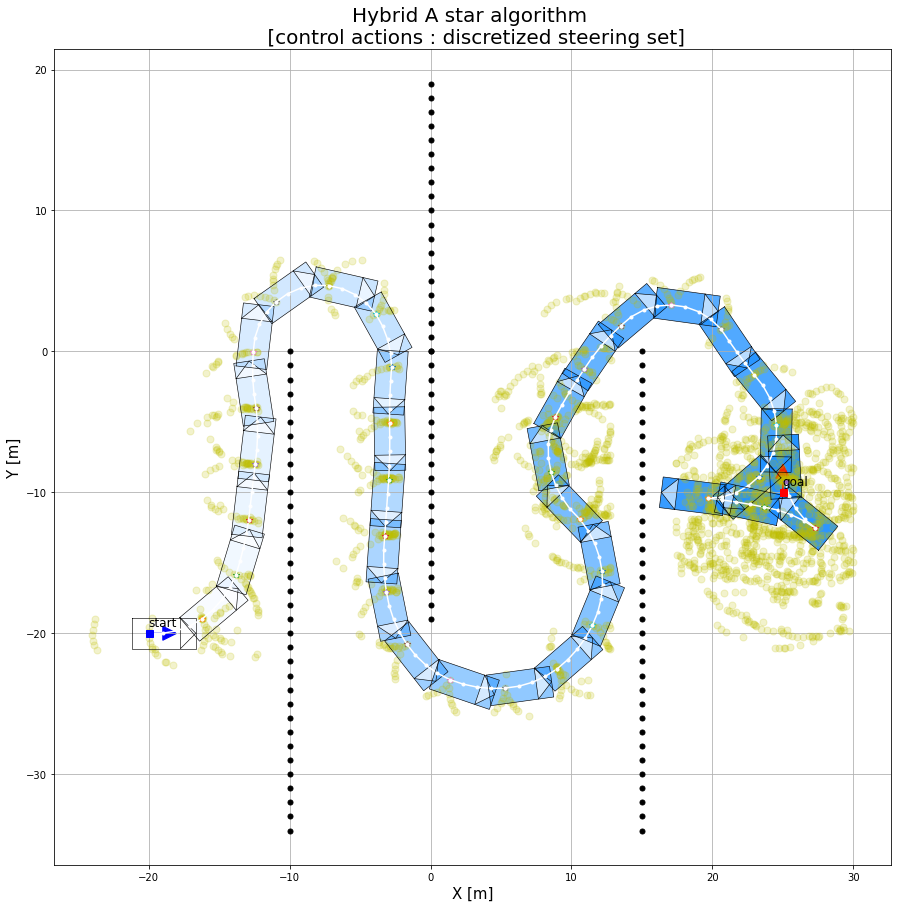

In [84]:
def main():
    
    # INITIALIZE - 1)start, 2)goal, 3)map
    start = (-20, -20, 0) 
    goal = (25, -10, 90)
    ox, oy = [], []
    for i in range(20):
        ox.append(0)
        oy.append(i)
        ox.append(0)
        oy.append(-i)
        
    for i in range(35):
        ox.append(-10)
        oy.append(-i)
        
    for i in np.arange(0,35):
        ox.append(15)
        oy.append(-i)        
        
    omap = [ox, oy]

    plt.figure(figsize=(15,15))
    
    opt_path = hybrid_a_star(start, goal, omap)

    opt_path = np.array(opt_path)

    if show_animation == True:
#         plt.figure(figsize=(10,10))
        plt.plot(ox, oy, '.k',  markersize=10)  
        for i in range(len(opt_path)):
            _path_x = opt_path[i][0]
            _path_y = opt_path[i][1]
            _path_yaw = opt_path[i][2]
            plt.plot(_path_x, _path_y, "w.-")
            plot_car(_path_x[-1], _path_y[-1], _path_yaw[-1], i, len(opt_path))
            
        plt.plot(start[0], start[1], 'bs',  markersize=7)
        plt.text(start[0], start[1]+0.5, 'start', fontsize=12)
        plt.plot(goal[0], goal[1], 'rs',  markersize=7)
        plt.text(goal[0], goal[1]+0.5, 'goal', fontsize=12)     
        plt.arrow(start[0], start[1], np.cos(np.deg2rad(start[2])), np.sin(np.deg2rad(start[2])), fc='b', ec='b', head_width=1, head_length=1)
        plt.arrow(goal[0], goal[1], np.cos(np.deg2rad(goal[2])), np.sin(np.deg2rad(goal[2])), fc='r', ec='r', head_width=1, head_length=1)
        
        plt.grid(True)
        plt.axis("equal")
        plt.xlabel("X [m]", fontsize=15), plt.ylabel("Y [m]", fontsize=15)
        plt.title("Hybrid A star algorithm \n [control actions : discretized steering set]", fontsize=20)
        plt.show()
    
    
if __name__ == "__main__":
    main()

In [ ]:
#     start = (10, 10, 90) 
#     goal = (50, 30, -90)
#     ox, oy = [], []
#     for i in range(61):
#         ox.append(i)
#         oy.append(0)
#     for i in range(61):
#         ox.append(0)
#         oy.append(i)
#     for i in range(61):
#         ox.append(i)
#         oy.append(60)
#     for i in range(60):
#         ox.append(60)
#         oy.append(i)
#     for i in range(51):
#         ox.append(30)
#         oy.append(i)
#     for i in range(16):
#         ox.append(30+i)
#         oy.append(20)
#     omap = [ox, oy]
